# AVemotion: A Multimodal Transformer for Real-Time Audio-Visual Emotion Recognition

## Section 1: File Discovery

In [63]:
import zipfile
import os

os.makedirs("ravdess", exist_ok=True)

with zipfile.ZipFile("/content/Audio_Speech_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess")

with zipfile.ZipFile("/content/Video_Speech_Actor_01.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess")


In [64]:
from glob import glob

audio_files = sorted(glob("ravdess/**/*.wav", recursive=True))
video_files = sorted(glob("ravdess/**/*.mp4", recursive=True))

print(f"Total audio files: {len(audio_files)}")
print(f"Total video files: {len(video_files)}")

Total audio files: 1440
Total video files: 120


## Section 2: Extract MFCC Features

In [65]:
import librosa
import numpy as np
from tqdm import tqdm

def extract_mfcc(file_path, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print(f"Error extracting MFCC from {file_path}: {e}")
        return np.zeros(n_mfcc)

# Run this to re-populate mfcc_features
mfcc_features = []
for af in tqdm(audio_files[:len(video_files)]):
    mfcc = extract_mfcc(af)
    mfcc_features.append(mfcc)

100%|██████████| 120/120 [00:01<00:00, 71.09it/s]


## Section 3: Extract Video Features (ResNet)

In [66]:
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

# Loading pretrained ResNet18 and remove final classification layer
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

# Defining transformation for video frames
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to extract ResNet features from video
def extract_video_features(video_path, frame_skip=30):
    cap = cv2.VideoCapture(video_path)
    features = []
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if i % frame_skip == 0:
            try:
                img = transform(frame).unsqueeze(0)
                with torch.no_grad():
                    feat = resnet(img).squeeze().numpy()
                features.append(feat)
            except Exception as e:
                print(f"Error in {video_path}: {e}")
        i += 1
    cap.release()
    return np.mean(features, axis=0) if features else np.zeros(512)

# Extracting video features for all video files
video_features = []
for vf in tqdm(video_files[:1440]):
    vfeat = extract_video_features(vf)
    video_features.append(vfeat)

print(f"Extracted features for {len(video_features)} video files.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [01:44<00:00,  1.15it/s]

Extracted features for 120 video files.


## Section 4: Dataset Assembly

In [67]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Sanity check
assert len(mfcc_features) == len(video_features), "Audio and video counts mismatch!"

# Combine audio + video features
features = [np.concatenate([mfcc, vis]) for mfcc, vis in zip(mfcc_features, video_features)]

# Extract emotion labels from audio filenames
def parse_emotion(file_path):
    emotion_code = int(os.path.basename(file_path).split("-")[2])
    emotion_map = {
        1: "neutral", 2: "calm", 3: "happy", 4: "sad",
        5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
    }
    return emotion_map.get(emotion_code, "unknown")

labels = [parse_emotion(f) for f in audio_files[:len(features)]]

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(labels)
X = np.array(features)


print("Combined feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", le.classes_)

Combined feature matrix shape: (120, 552)
Labels shape: (120,)
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


## Section 4: Model Definition

In [68]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionFusionEmotionClassifier(nn.Module):
    def __init__(self, audio_dim=40, video_dim=512, hidden_dim=256, num_classes=8):
        super().__init__()
        self.audio_proj = nn.Sequential(
            nn.Linear(audio_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.video_proj = nn.Sequential(
            nn.Linear(video_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        audio_feat = self.audio_proj(x[:, :40])
        video_feat = self.video_proj(x[:, 40:])
        concat = torch.stack([audio_feat, video_feat], dim=1)
        attn_output, _ = self.attn(concat, concat, concat)
        fused = attn_output.mean(dim=1)
        return self.classifier(fused)

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# Defining your TransformerEmotionClassifier
class TransformerEmotionClassifier(nn.Module):
    def __init__(self, input_dim=552, hidden_dim=256, num_heads=4, num_classes=8):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # (B, 1, H)
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.classifier(x)

## Section 5: Training

In [89]:
# Converting data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Splitting into dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initializing model
model = TransformerEmotionClassifier(input_dim=552, hidden_dim=256, num_heads=4, num_classes=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Training loop
losses = []
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = F.cross_entropy(out, yb, weight=class_weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "best_model.pt")
print("Model saved as best_model.pt")

Epoch 1, Loss: 8.5593
Epoch 2, Loss: 8.4388
Epoch 3, Loss: 8.5878
Epoch 4, Loss: 8.4772
Epoch 5, Loss: 8.3932
Epoch 6, Loss: 8.4445
Epoch 7, Loss: 8.3669
Epoch 8, Loss: 8.3136
Epoch 9, Loss: 8.2590
Epoch 10, Loss: 8.1991
Epoch 11, Loss: 8.3051
Epoch 12, Loss: 8.2586
Epoch 13, Loss: 7.9013
Epoch 14, Loss: 7.6645
Epoch 15, Loss: 7.6215
Epoch 16, Loss: 7.6745
Epoch 17, Loss: 7.5924
Epoch 18, Loss: 7.3561
Epoch 19, Loss: 7.0458
Epoch 20, Loss: 6.7517
Epoch 21, Loss: 6.2204
Epoch 22, Loss: 6.4454
Epoch 23, Loss: 6.8984
Epoch 24, Loss: 6.2854
Epoch 25, Loss: 5.9964
Epoch 26, Loss: 5.4814
Epoch 27, Loss: 5.0447
Epoch 28, Loss: 5.6832
Epoch 29, Loss: 5.2470
Epoch 30, Loss: 4.6896
Epoch 31, Loss: 5.1659
Epoch 32, Loss: 4.6858
Epoch 33, Loss: 4.1742
Epoch 34, Loss: 4.5144
Epoch 35, Loss: 4.5600
Epoch 36, Loss: 4.4719
Epoch 37, Loss: 3.7178
Epoch 38, Loss: 4.6999
Epoch 39, Loss: 4.0616
Epoch 40, Loss: 4.0180
Epoch 41, Loss: 3.4467
Epoch 42, Loss: 3.0196
Epoch 43, Loss: 3.5006
Epoch 44, Loss: 3.09

## Section 6: Evaluation

In [90]:
# Evaluating the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

# Classification report
from sklearn.metrics import classification_report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))



📊 Classification Report:
              precision    recall  f1-score   support

       angry       0.71      0.75      0.73        16
        calm       0.70      1.00      0.82        16
     disgust       0.89      1.00      0.94        16
     fearful       0.94      1.00      0.97        16
       happy       0.92      0.75      0.83        16
     neutral       0.75      0.38      0.50         8
         sad       1.00      0.56      0.72        16
   surprised       0.79      0.94      0.86        16

    accuracy                           0.82       120
   macro avg       0.84      0.80      0.80       120
weighted avg       0.84      0.82      0.82       120



## Section 7: Explainability Plots

SHAP shape: (1, 552)
Sample shape: torch.Size([1, 552])


<ipython-input-91-3974740447>:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


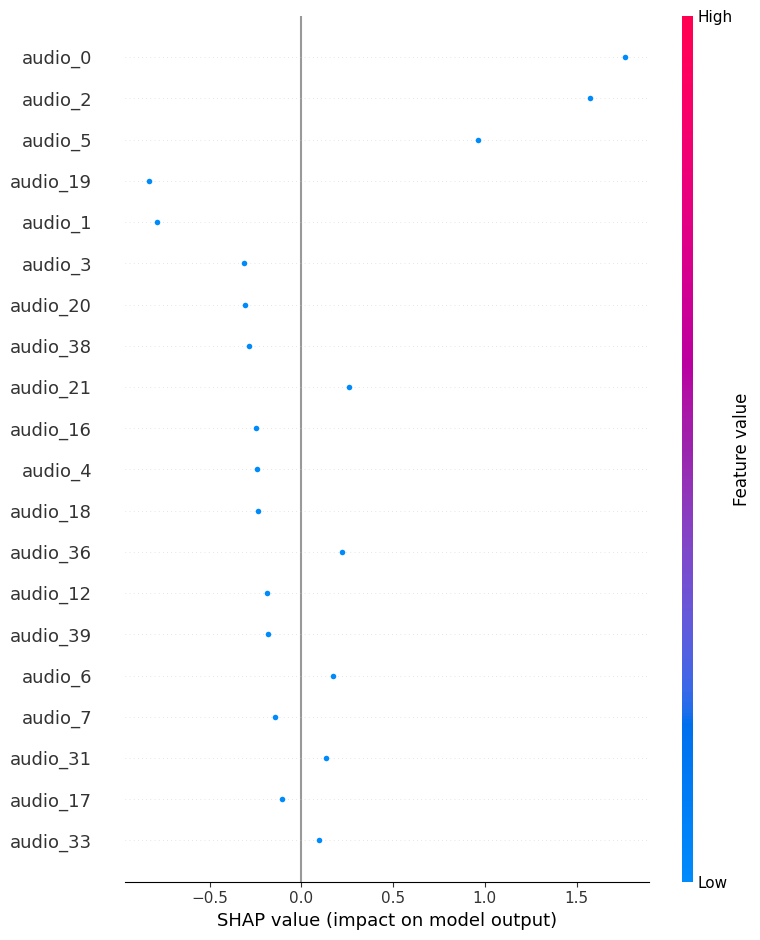

In [91]:
# SHAP Summary Plot
import shap
import torch.nn as nn

# Wrapper to output (batch_size, 1)
class WrapperModel(nn.Module):
    def __init__(self, base_model, class_idx):
        super().__init__()
        self.base_model = base_model
        self.class_idx = class_idx

    def forward(self, x):
        return self.base_model(x)[:, self.class_idx].unsqueeze(1)

# Selecting class and create wrapper model
class_idx = 0
wrapped_model = WrapperModel(model, class_idx).to(device).eval()

# Selecting 1 sample to explain
background = torch.tensor(X[:100], dtype=torch.float32).to(device)
sample = torch.tensor(X[100:101], dtype=torch.float32).to(device)

# SHAP explanation
explainer = shap.GradientExplainer(wrapped_model, background)
shap_vals = explainer.shap_values(sample)

shap_array = np.array(shap_vals[0].T)
print("SHAP shape:", shap_array.shape)
print("Sample shape:", sample.shape)

# Plotting
shap.summary_plot(
    shap_array,
    sample.cpu().numpy(),
    feature_names=[f'audio_{i}' if i < 40 else f'video_{i-40}' for i in range(sample.shape[1])]
)

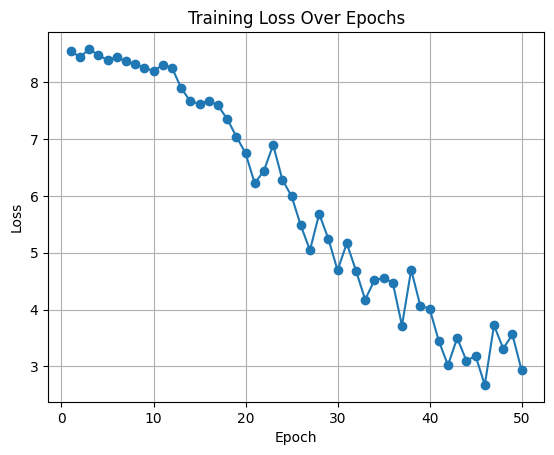

In [92]:
# Line graph that tracks training Loss Over Epochs
import matplotlib.pyplot as plt

plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

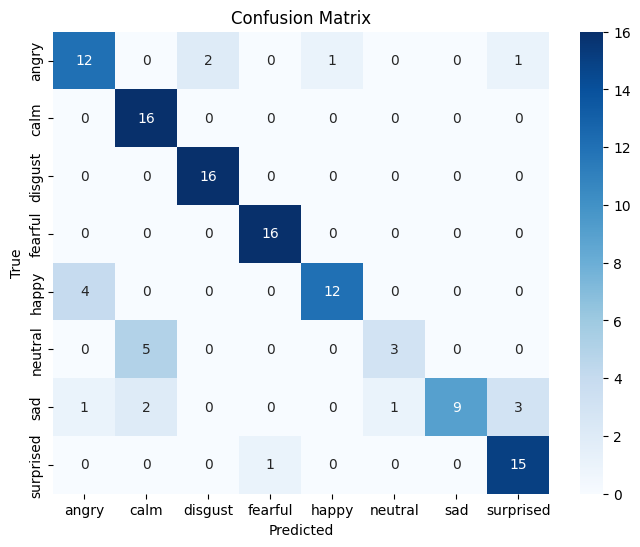

In [93]:
# Confusion Matrix that shows actual vs. predicted emotion labels
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


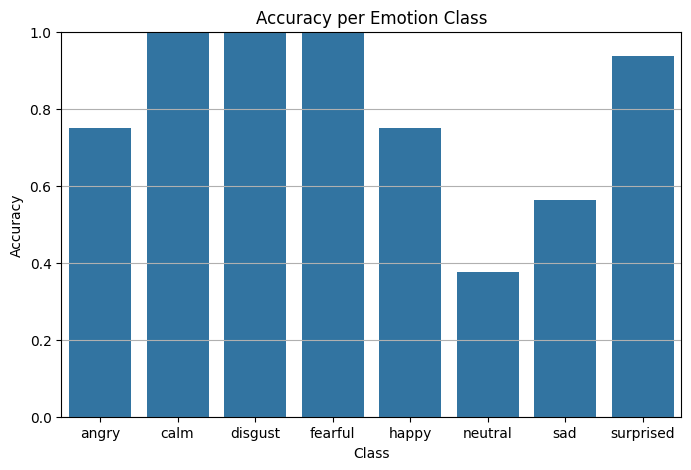

In [94]:
# Bar plot that represents the classification accuracy for one emotion
import pandas as pd

cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
correct_per_class = cm_df.values.diagonal()
total_per_class = cm_df.sum(axis=1)
accuracy_per_class = correct_per_class / total_per_class

plt.figure(figsize=(8,5))
sns.barplot(x=le.classes_, y=accuracy_per_class)
plt.title("Accuracy per Emotion Class")
plt.ylabel("Accuracy")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

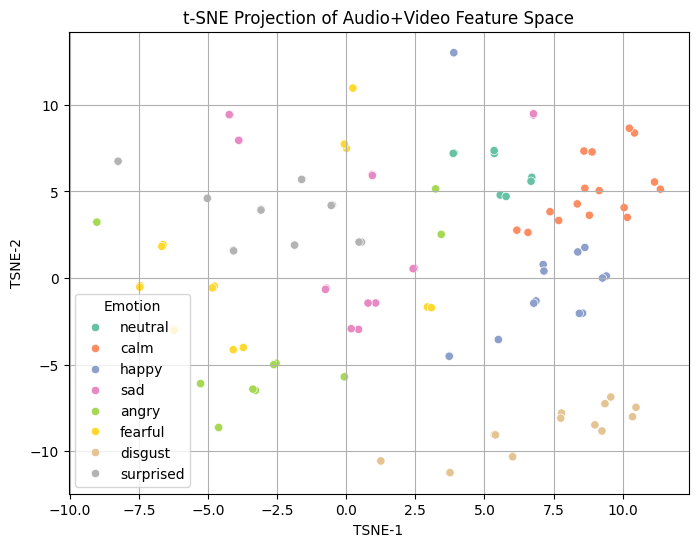

In [95]:
# t-SNE plot that validates the feature encoding quality visually.
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Reduce dimensionality for visualization
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting with original emotion labels
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=le.inverse_transform(y), palette="Set2")
plt.title("t-SNE Projection of Audio+Video Feature Space")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Emotion")
plt.grid(True)
plt.show()